# Реализация поканальной сепарабельной свёртки

В этом уроке мы рассмотрим, как на TensorFlow можно реализовать поканальную сепарабельную свёртку. Для этого создадим некоторую модель свёрточной нейронной сети (с обычными свёрточными слоями), а затем заменим в ней некоторые свёрточные слои на поканальные сепарабельные свёртки. 

Затем мы сравним две полученные сети (исходную и оптимизированную) по скорости работы.

Так как здесь нас волнует лишь скорость работы нейросетей и измерить мы это можем со случайнми весами и случайным входом, обойдёмся без обучения этих моделей.

### Используем TensorFlow 2.0

На момент подготовки этих материалов в Google Colab по умолчанию используется версия TensorFlow 1.X

Переключаемся на версию 2.0 (работает только в Colab)

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


### Загрузка библиотек

In [ ]:
import numpy as np

import tensorflow as tf

### Создание обычной свёрточной нейросети

Создадим обычную Sequential свёрточную нейросеть для классифкации с использованием большого количества свёрточных слоёв.

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),

    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),

    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),

    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

# Warm-up
_ = model1(np.random.rand(1, 512, 512, 3).astype(np.float32))

### Создание свёрточной сети с использованием поканальных сепарабельных свёрток

Теперь создадим другую похожую модель, где заменим часть свёрточнх слоёв на поканальные сепарабельные свёртки (depth-wise conv + conv1x1).

Однако, не все свёрточне слои имеет смысл заменять на комбинацию двух свёрточных слоёв, так как не всегда это будет в итоге быстрее.

Например, ранние свёртки с 32 и 64 каналами будут работать и так достаточно быстро и не получится добыть большое ускорение за счёт depth-wise свёрток.

А вот свёрточные слои с 128 каналами (в данном конкретном примере) заменить можно. Всё это следует из экспериментов (надо попробовать по-разному и сравнить время работы).

Поканальная свёртка реализуется слоем `DepthwiseConv2D`. Он похож на обычный свёрточный слой, но у него в параметрах отсутствует количество выходных каналов.

**[Вопрос]** Почему?



In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),

    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.DepthwiseConv2D((5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu'),
    tf.keras.layers.DepthwiseConv2D((5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu'),

    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

# Warm-up
_ = model2(np.random.rand(1, 512, 512, 3).astype(np.float32))

### Сравнение скорости работы двух моделей

Запустим инференс для обеих моделей со случайным входом и узнаем среднюю скорость работы каждой из моделей с помощью магической команды `%%timeit`

In [ ]:
%%timeit -n 10 -r 10

q = model1(np.random.rand(1, 512, 512, 3).astype(np.float32))

10 loops, best of 10: 20.7 ms per loop


In [ ]:
%%timeit -n 10 -r 10

q = model2(np.random.rand(1, 512, 512, 3).astype(np.float32))

10 loops, best of 10: 16.7 ms per loop


Модель с поканальными сепарабельными свёртками получилась быстрее.

В этом примере мы никак не сравнивали качество двух моделей, так как для этого нужно было бы их обучить, а они слишком большие (обучение заняло бы длительное время). А на маленьких моделях такая замена не дала бы существенного прироста. На практике мы заметим небольшое подение качества, однако, зачастую можно пожертвовать несколькими процентами точности распозавания ради ускорения в несколько раз.

**[Задание 1]** Сравните скорость работы обычного свёрточного слоя и аналогичной поканальной сепарабельной свёртки (depth-wise conv + conv1x1) при различных гиперпараметрах. Зафиксируйте пространственный размер входа (128x128) и размер ядра (5x5). Варьируйте количество входных и выходных каналов и для каждой такой пары сравние скорость работы обычно свёрточного слоя и поканальной сепарабельной свёртки. Должны получиться две двумерных таблицы. Из двух таблиц получите одну -- во сколько раз один тип архтектуры быстрее другого. Визуализируйте получившуются таблицу с помощью `matplotlib`, как показано ниже.
Для этого задания вам понадобится самостоятельно реализовать способ измерения среднего времени инференса модели.

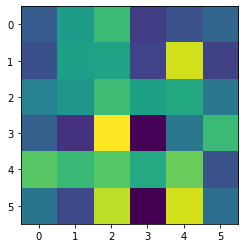

In [ ]:
import matplotlib.pyplot as plt

# пример случайной таблицы
matrix = np.random.rand(6, 6)

# цвет характеризует величину
plt.imshow(matrix)